# 1. Batch Size Effect

In [1]:
### import libraries

# for DL modeling
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split

# for number-crunching
import numpy as np
import scipy.stats as stats

# for dataset management
import pandas as pd

# for timing computations
import time

# for data visualization
import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

### 1.1 Data Processing

In [3]:
# import the data
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
data = pd.read_csv(url,sep=';')
data = data[data['total sulfur dioxide']<200] # drop a few outliers

# z-score all columns except for quality
cols2zscore = data.keys()
cols2zscore = cols2zscore.drop('quality')
data[cols2zscore] = data[cols2zscore].apply(stats.zscore)

# create a new column for binarized (boolean) quality
data['boolQuality'] = 0
# data['boolQuality'][data['quality']<6] = 0 # implicit in the code! just here for clarity
data['boolQuality'][data['quality']>5] = 1

# convert from pandas dataframe to tensor
dataT  = torch.tensor( data[cols2zscore].values ).float()
labels = torch.tensor( data['boolQuality'].values ).float()
labels = labels[:,None] # transform to matrix


# use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(dataT, labels, test_size=.1)

# then convert them into PyTorch Datasets (note: already converted to tensors)
train_dataDataset = TensorDataset(train_data,train_labels)
test_dataDataset  = TensorDataset(test_data,test_labels)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


### 1.2 Training and Evaluating the model

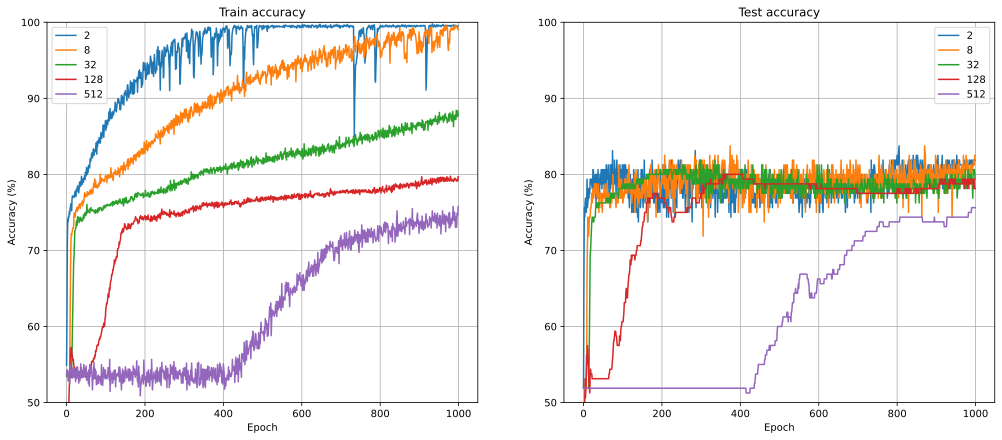

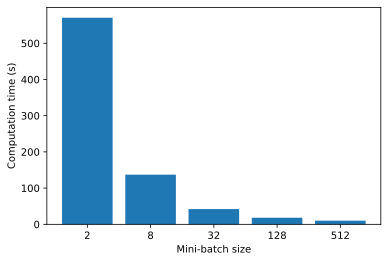

In [4]:
# create a class for the model

class ANNwine(nn.Module):
  def __init__(self):
    super().__init__()

    ### input layer
    self.input = nn.Linear(11,16)
    
    ### hidden layers
    self.fc1 = nn.Linear(16,32)
    self.fc2 = nn.Linear(32,32)

    ### output layer
    self.output = nn.Linear(32,1)
  
  # forward pass
  def forward(self,x):
    x = F.relu( self.input(x) )
    x = F.relu( self.fc1(x) ) # fully connected
    x = F.relu( self.fc2(x) )
    return self.output(x)


# a function that trains the model

# global parameter
numepochs = 1000

def trainTheModel():

  # loss function and optimizer
  lossfun = nn.BCEWithLogitsLoss()
  optimizer = torch.optim.SGD(winenet.parameters(),lr=.01)

  # initialize losses
  losses   = torch.zeros(numepochs)
  trainAcc = []
  testAcc  = []

  # loop over epochs
  for epochi in range(numepochs):

    # switch on training mode
    winenet.train()

    # loop over training data batches
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = winenet(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # compute training accuracy for this batch
      batchAcc.append( 100*torch.mean(((yHat>0) == y).float()).item() )
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)

    # test accuracy
    winenet.eval()
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    with torch.no_grad(): # deactivates autograd
      yHat = winenet(X)
    testAcc.append( 100*torch.mean(((yHat>0) == y).float()).item() )
  
  # function output
  return trainAcc,testAcc,losses



  # This cell takes ~15 mins

# range of batch sizes
batchsizes = 2**np.arange(1,10,2)

# initialize output results matrices
accuracyResultsTrain = np.zeros((numepochs,len(batchsizes)))
accuracyResultsTest  = np.zeros((numepochs,len(batchsizes)))
comptime             = np.zeros(len(batchsizes))

# test data doesn't vary by training batch size
test_loader = DataLoader(test_dataDataset,batch_size=test_dataDataset.tensors[0].shape[0])

# loop over batch sizes
for bi in range(len(batchsizes)):

  # start the clock!
  starttime = time.process_time()

  # create dataloader object
  train_loader = DataLoader(train_dataDataset,
                          batch_size=int(batchsizes[bi]), shuffle=True, drop_last=True)

  # create and train a model
  winenet = ANNwine()
  trainAcc,testAcc,losses = trainTheModel()

  # store data
  accuracyResultsTrain[:,bi] = trainAcc
  accuracyResultsTest[:,bi]  = testAcc

  # check the timer
  comptime[bi] = time.process_time() - starttime


# plot some results
fig,ax = plt.subplots(1,2,figsize=(17,7))

ax[0].plot(accuracyResultsTrain)
ax[0].set_title('Train accuracy')
ax[1].plot(accuracyResultsTest)
ax[1].set_title('Test accuracy')

# common features
for i in range(2):
  ax[i].legend(batchsizes)
  ax[i].set_xlabel('Epoch')
  ax[i].set_ylabel('Accuracy (%)')
  ax[i].set_ylim([50,100])
  ax[i].grid()

plt.show()



# bar plot of computation time
plt.bar(range(len(comptime)),comptime,tick_label=batchsizes)
plt.xlabel('Mini-batch size')
plt.ylabel('Computation time (s)')
plt.show()

#2. Batch Normalization

In [5]:
# create a class for the model WITH BATCH NORM

class ANNwine_withBNorm(nn.Module):
  def __init__(self):
    super().__init__()

    ### input layer
    self.input = nn.Linear(11,16)
    
    ### hidden layers
    self.fc1    = nn.Linear(16,32)
    self.bnorm1 = nn.BatchNorm1d(16) # the number of units into this layer
    self.fc2    = nn.Linear(32,20)
    self.bnorm2 = nn.BatchNorm1d(32) # the number of units into this layer

    ### output layer
    self.output = nn.Linear(20,1)
  
  # forward pass
  def forward(self,x,doBN):

    # input (x starts off normalized)
    x = F.relu( self.input(x) )


    if doBN:
      # hidden layer 1
      x = self.bnorm1(x) # batchnorm
      x = self.fc1(x)    # weighted combination
      x = F.relu(x)      # activation function

      # hidden layer 2
      x = self.bnorm2(x) # batchnorm
      x = self.fc2(x)    # weighted combination
      x = F.relu(x)      # activation function
    

    else:
      # hidden layer 1
      x = F.relu( self.fc1(x) )

      # hidden layer 2
      x = F.relu( self.fc2(x) )

    # output layer
    return self.output(x)

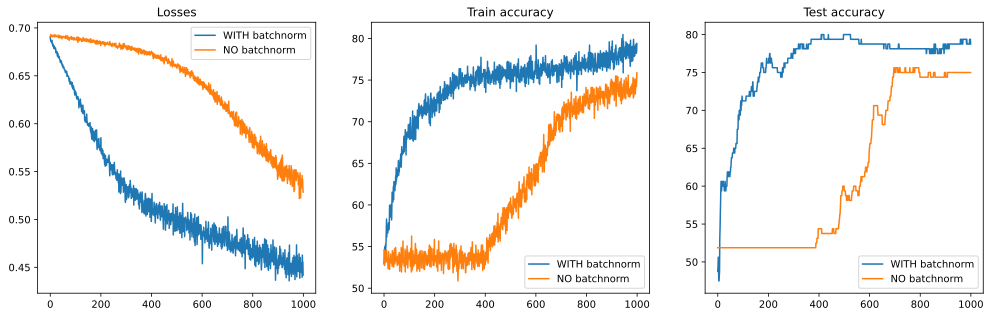

In [6]:
# a function that trains the model

# global parameter
numepochs = 1000

def trainTheModel(doBN=True):

  # loss function and optimizer
  lossfun = nn.BCEWithLogitsLoss()
  optimizer = torch.optim.SGD(winenet.parameters(),lr=.01)

  # initialize losses
  losses   = torch.zeros(numepochs)
  trainAcc = []
  testAcc  = []

  # loop over epochs
  for epochi in range(numepochs):

    # switch on training mode
    winenet.train()

    # loop over training data batches
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = winenet(X,doBN)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # compute training accuracy for this batch
      batchAcc.append( 100*torch.mean(((yHat>0) == y).float()).item() )
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)



    ### test accuracy

    # NOTE: batch normalization should be turned off during testing, so we definitely need to switch modes here
    winenet.eval()
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    with torch.no_grad(): # deactivates autograd
      yHat = winenet(X,doBN)
    testAcc.append( 100*torch.mean(((yHat>0) == y).float()).item() )
  
  # function output
  return trainAcc,testAcc,losses


# create and train a model NO BATCHNORM
winenet = ANNwine_withBNorm()
trainAccNo,testAccNo,lossesNo = trainTheModel(False)

# create and train a model WITH BATCHNORM
winenet = ANNwine_withBNorm()
trainAccWith,testAccWith,lossesWith = trainTheModel(True)

# plot the results
fig,ax = plt.subplots(1,3,figsize=(17,5))

ax[0].plot(lossesWith,label='WITH batchnorm')
ax[0].plot(lossesNo,label='NO batchnorm')
ax[0].set_title('Losses')
ax[0].legend()

ax[1].plot(trainAccWith,label='WITH batchnorm')
ax[1].plot(trainAccNo,label='NO batchnorm')
ax[1].set_title('Train accuracy')
ax[1].legend()

ax[2].plot(testAccWith,label='WITH batchnorm')
ax[2].plot(testAccNo,label='NO batchnorm')
ax[2].set_title('Test accuracy')
ax[2].legend()

plt.show()

# 3. Activation Functions

### 3.1 Common Activation Functions

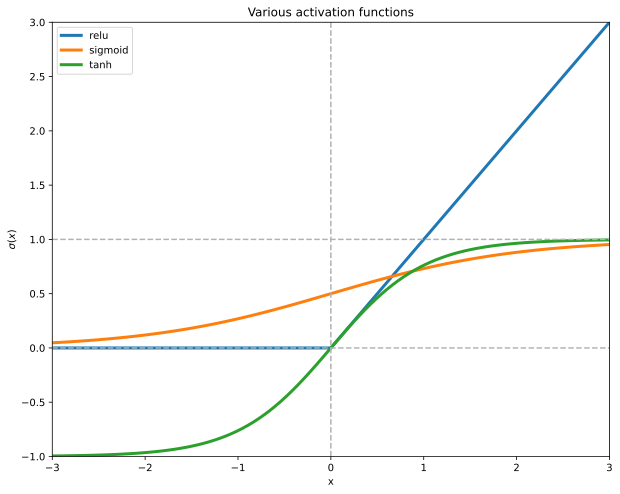

In [7]:
# variable to evaluate over
x = torch.linspace(-3,3,101)

# create a function that returns the activated output
def NNoutputx(actfun):
  # get activation function type
  # this code replaces torch.relu with torch.<actfun>
  actfun = getattr(torch,actfun)
  return actfun( x )



# the activation functions
activation_funs = [ 'relu', 'sigmoid', 'tanh' ]

fig = plt.figure(figsize=(10,8))

for actfun in activation_funs:
  plt.plot(x,NNoutputx(actfun),label=actfun,linewidth=3)

# add reference lines
dashlinecol = [.7,.7,.7]
plt.plot(x[[0,-1]],[0,0],'--',color=dashlinecol)
plt.plot(x[[0,-1]],[1,1],'--',color=dashlinecol)
plt.plot([0,0],[-1,3],'--',color=dashlinecol)

# make the plot look nicer
plt.legend()
plt.xlabel('x')
plt.ylabel('$\sigma(x)$')
plt.title('Various activation functions')
plt.xlim(x[[0,-1]])
plt.ylim([-1,3])
plt.show()



### 3.2 More Activation Functions

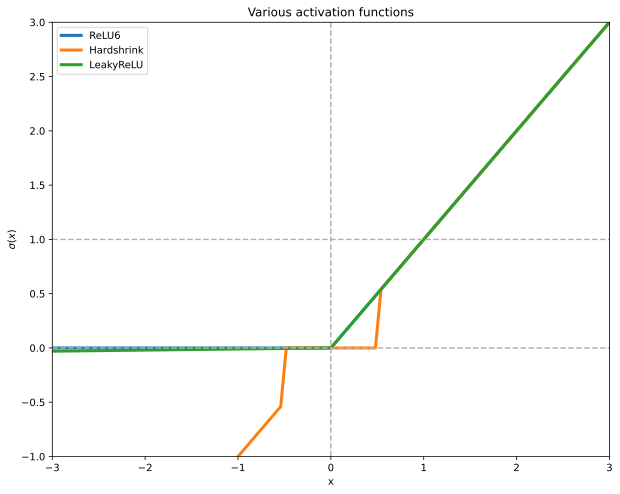

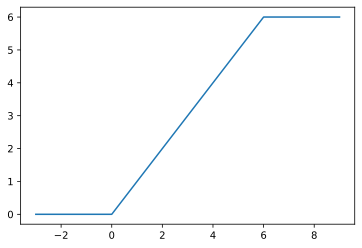

In [8]:
# create a function that returns the activated output FUNCTION
# this is different from the previous function
def NNoutput(actfun):
  # get activation function type
  # this code replaces torch.nn.relu with torch.nn.<actfun>
  actfun = getattr(torch.nn,actfun)
  return actfun()


# the activation functions
activation_funs = [ 'ReLU6', 'Hardshrink', 'LeakyReLU' ]

fig = plt.figure(figsize=(10,8))

for actfun in activation_funs:
  plt.plot(x,NNoutput(actfun)(x),label=actfun,linewidth=3)

# add reference lines
dashlinecol = [.7,.7,.7]
plt.plot(x[[0,-1]],[0,0],'--',color=dashlinecol)
plt.plot(x[[0,-1]],[1,1],'--',color=dashlinecol)
plt.plot([0,0],[-1,3],'--',color=dashlinecol)

# make the plot look nicer
plt.legend()
plt.xlabel('x')
plt.ylabel('$\sigma(x)$')
plt.title('Various activation functions')
plt.xlim(x[[0,-1]])
plt.ylim([-1,3])
# plt.ylim([-.1,.1])
plt.show()

# relu6 in more detail
x = torch.linspace(-3,9,101)
relu6 = torch.nn.ReLU6()

plt.plot(x,relu6(x))
plt.show()


### 3.3 Difference between torch and torch.nn

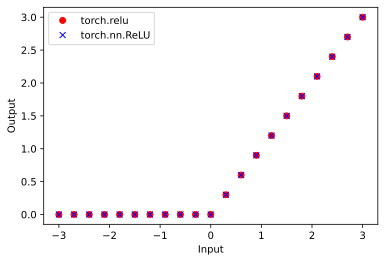

In [9]:
# redefine x (fewer points to facilitate visualization)
x = torch.linspace(-3,3,21)

# in torch
y1 = torch.relu(x)

# in torch.nn
f = torch.nn.ReLU()
y2 = f(x)


# the results are the same
plt.plot(x,y1,'ro',label='torch.relu')
plt.plot(x,y2,'bx',label='torch.nn.ReLU')
plt.legend()
plt.xlabel('Input')
plt.ylabel('Output')
plt.show()

# List of activation functions in PyTorch:
#  https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity

### 3.4 Compare Activation Functions

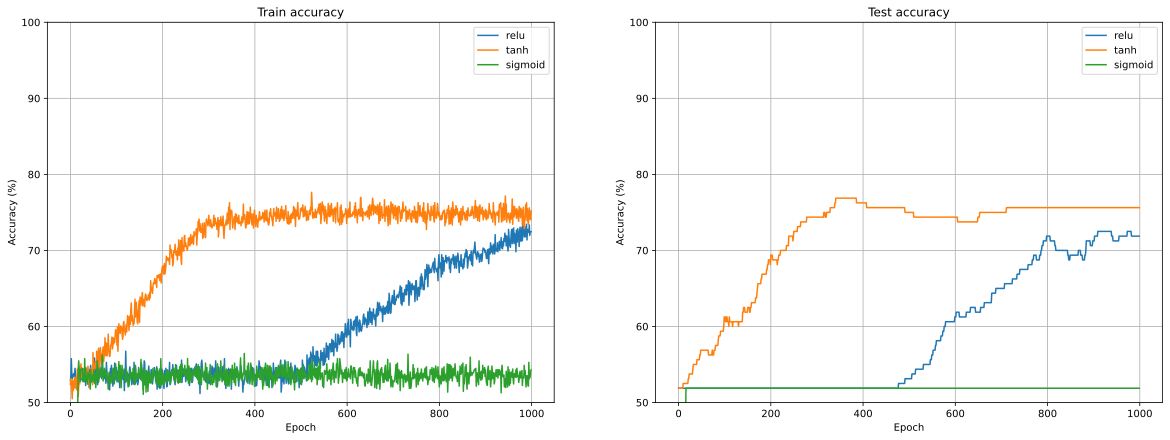

In [10]:
# create a class for the model

class ANNwine(nn.Module):
  def __init__(self,actfun):
    super().__init__()

    ### input layer
    self.input = nn.Linear(11,16)
    
    ### hidden layers
    self.fc1 = nn.Linear(16,32)
    self.fc2 = nn.Linear(32,32)

    ### output layer
    self.output = nn.Linear(32,1)

    # activation funcion to pass through
    self.actfun = actfun
  
  # forward pass
  def forward(self,x):
    # get activation function type
    # this code replaces torch.relu with torch.<self.actfun>
    actfun = getattr(torch,self.actfun)
    x = actfun( self.input(x) )
    x = actfun( self.fc1(x) )
    x = actfun( self.fc2(x) )
    return self.output(x)

# test the model
# use sigmoid, relu, tanh
net = ANNwine('sigmoid')
net( torch.randn(10,11) ).shape


# a function that trains the model

# global parameter
numepochs = 1000

def trainTheModel():

  # loss function and optimizer
  lossfun = nn.BCEWithLogitsLoss()
  optimizer = torch.optim.SGD(winenet.parameters(),lr=.01)

  # initialize losses
  losses   = torch.zeros(numepochs)
  trainAcc = []
  testAcc  = []

  # loop over epochs
  for epochi in range(numepochs):

    # turn on training mode
    winenet.train()

    # loop over training data batches
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = winenet(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # compute training accuracy for this batch
      batchAcc.append( 100*torch.mean(((yHat>0) == y).float()).item() )
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)

    # test accuracy
    winenet.eval()
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    with torch.no_grad(): # deactivates autograd
      yHat = winenet(X)
    testAcc.append( 100*torch.mean(((yHat>0) == y).float()).item() )
  
  # function output
  return trainAcc,testAcc,losses

  # list activation functions to test
activation_funs = [ 'relu', 'tanh', 'sigmoid' ]

trainByAct = np.zeros((numepochs,len(activation_funs)))
testByAct  = np.zeros((numepochs,len(activation_funs)))

for ai,actfun in enumerate(activation_funs):
  # create a model and train it
  winenet = ANNwine(actfun)
  trainByAct[:,ai],testByAct[:,ai],losses = trainTheModel()


# plot some results
fig,ax = plt.subplots(1,2,figsize=(20,7))

ax[0].plot(trainByAct)
ax[0].set_title('Train accuracy')
ax[1].plot(testByAct)
ax[1].set_title('Test accuracy')

# common features
for i in range(2):
  ax[i].legend(activation_funs)
  ax[i].set_xlabel('Epoch')
  ax[i].set_ylabel('Accuracy (%)')
  ax[i].set_ylim([50,100])
  ax[i].grid()

plt.show()

# 4. Loss functions

### 4.1 Mean Square Error

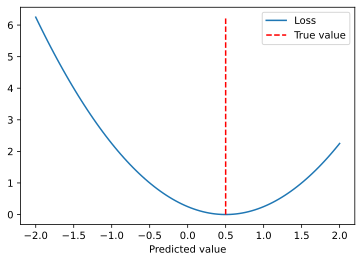

In [11]:
# loss function
lossfunMSE = nn.MSELoss()

# create predictions and real answer
yHat = torch.linspace(-2,2,101)
y = torch.tensor(.5)

# compute MSE loss function
L = np.zeros(101)
for i,yy in enumerate(yHat):
  L[i] = lossfunMSE(yy,y)

plt.plot(yHat,L,label='Loss')
plt.plot([y,y],[0,np.max(L)],'r--',label='True value')
plt.xlabel('Predicted value')
plt.legend()
plt.show()

### 4.2 Binary Cross Entropy

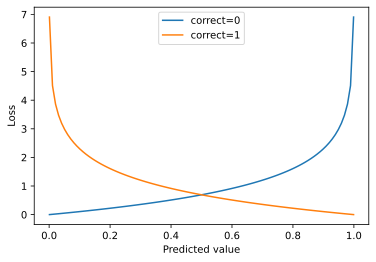

tensor(0.3665)
tensor(0.1269)
tensor(0.1269)


In [15]:
# loss function
lossfunBCE = nn.BCELoss()

# create predictions and real answer
yHat = torch.linspace(.001,.999,101)
y1 = torch.tensor(0.)
y2 = torch.tensor(1.)

# compute MSE loss function
L = np.zeros((101,2))
for i,yy in enumerate(yHat):
  L[i,0] = lossfunBCE(yy,y1) # 0 is the correct answer
  L[i,1] = lossfunBCE(yy,y2) # 1 is the correct answer

plt.plot(yHat,L)
plt.xlabel('Predicted value')
plt.ylabel('Loss')
plt.legend(['correct=0','correct=1'])
# plt.yscale('log')
plt.show()

# The example above shows data already in probabilities. Raw outputs will need to be converted to probabilities:

# "raw" output of a model
yHat = torch.tensor(2.)
print(lossfunBCE(np.log(yHat),y2))

# convert to prob via sigmoid
sig = nn.Sigmoid()
print(lossfunBCE( sig(yHat) ,y2))


# However, PyTorch recommends using a single function that incorporates sigmoid+BCE due to increased numerical stability.
# https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html?highlight=nn%20bcewithlogitsloss#torch.nn.BCEWithLogitsLoss


# Thus, the recommended way to do it:
lossfunBCE = nn.BCEWithLogitsLoss()
yHat = torch.tensor(2.)
print(lossfunBCE(yHat,y2))

# In toy examples, numerical accuracy usually isn't a problem.

### 4.3 Categorical cross-entropy

In [16]:
# loss function
lossfunCCE = nn.CrossEntropyLoss()

# vector of output layer (pre-softmax)
yHat = torch.tensor([[1.,4,3]])

for i in range(3):
  correctAnswer = torch.tensor([i])
  thisloss = lossfunCCE(yHat,correctAnswer).item()
  print( 'Loss when correct answer is %g: %g' %(i,thisloss) )


# Repeat using pre-softmaxified output
sm = nn.Softmax(dim=1)
yHat_sm = sm(yHat)

for i in range(3):
  correctAnswer = torch.tensor([i])
  thisloss = lossfunCCE(yHat_sm,correctAnswer).item()
  print( 'Loss when correct answer is %g: %g' %(i,thisloss) )

# compare raw, softmax, and log-softmax outputs
sm = nn.LogSoftmax(dim=1)
yHat_logsm = sm(yHat)

# print them
print(yHat)
print(yHat_sm)
print(yHat_logsm)

Loss when correct answer is 0: 3.34901
Loss when correct answer is 1: 0.349012
Loss when correct answer is 2: 1.34901
Loss when correct answer is 0: 1.43658
Loss when correct answer is 1: 0.766318
Loss when correct answer is 2: 1.21221
tensor([[1., 4., 3.]])
tensor([[0.0351, 0.7054, 0.2595]])
tensor([[-3.3490, -0.3490, -1.3490]])


### 4.4 Create Own Loss Function

In [17]:
class myLoss(nn.Module): # inherent info from nn.Module
  def __init__(self):
    super().__init__()
      
  def forward(self,x,y):
    loss = torch.abs(x-y)
    return loss

# test it out!
lfun = myLoss()
lfun(torch.tensor(4),torch.tensor(5.2))

tensor(1.2000)

# 5. Multiple Output

### 5.1 Create the data

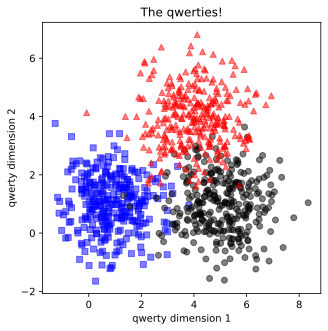

There are 50 batches, each with 16 samples.


In [18]:
# create data

nPerClust = 300
blur = 1

A = [ 1, 1 ]
B = [ 5, 1 ]
C = [ 4, 4 ]

# generate data
a = [ A[0]+np.random.randn(nPerClust)*blur , A[1]+np.random.randn(nPerClust)*blur ]
b = [ B[0]+np.random.randn(nPerClust)*blur , B[1]+np.random.randn(nPerClust)*blur ]
c = [ C[0]+np.random.randn(nPerClust)*blur , C[1]+np.random.randn(nPerClust)*blur ]

# true labels
labels_np = np.hstack((  np.zeros((nPerClust)),
                         np.ones( (nPerClust)),
                       1+np.ones( (nPerClust))  ))

# concatanate into a matrix
data_np = np.hstack((a,b,c)).T

# convert to a pytorch tensor
data = torch.tensor(data_np).float()
labels = torch.tensor(labels_np).long() # note: "long" format for CCE

# show the data
fig = plt.figure(figsize=(5,5))
plt.plot(data[np.where(labels==0)[0],0],data[np.where(labels==0)[0],1],'bs',alpha=.5)
plt.plot(data[np.where(labels==1)[0],0],data[np.where(labels==1)[0],1],'ko',alpha=.5)
plt.plot(data[np.where(labels==2)[0],0],data[np.where(labels==2)[0],1],'r^',alpha=.5)
plt.title('The qwerties!')
plt.xlabel('qwerty dimension 1')
plt.ylabel('qwerty dimension 2')
plt.show()


# use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(data, labels, test_size=.1)

# then convert them into PyTorch Datasets (note: already converted to tensors)
train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)

# finally, translate into dataloader objects
batchsize    = 16
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

# how many batches are there?

print(f'There are {len(train_loader)} batches, each with {batchsize} samples.')

### 5.2 Create and Validate the model

In [19]:
# create a class for the model
def createTheQwertyNet():

  class qwertyNet(nn.Module):
    def __init__(self):
      super().__init__()

      ### input layer
      self.input = nn.Linear(2,8)
      
      ### hidden layer
      self.fc1 = nn.Linear(8,8)

      ### output layer
      self.output = nn.Linear(8,3)

    # forward pass
    def forward(self,x):
      x = F.relu( self.input(x) )
      x = F.relu( self.fc1(x) )
      return self.output(x)
  
  # create the model instance
  net = qwertyNet()
  
  # loss function
  lossfun = nn.CrossEntropyLoss()

  # optimizer
  optimizer = torch.optim.SGD(net.parameters(),lr=.01)

  return net,lossfun,optimizer


  # test the model with fake input

net,lossf,opt = createTheQwertyNet()
print(net)

# input is ten samples
input = torch.rand(10,2)
net(input)

qwertyNet(
  (input): Linear(in_features=2, out_features=8, bias=True)
  (fc1): Linear(in_features=8, out_features=8, bias=True)
  (output): Linear(in_features=8, out_features=3, bias=True)
)


tensor([[-0.2630,  0.0180, -0.1444],
        [-0.2759,  0.0099, -0.1506],
        [-0.2636,  0.0178, -0.1541],
        [-0.2644,  0.0176, -0.1381],
        [-0.2536,  0.0263, -0.1542],
        [-0.2709,  0.0139, -0.1766],
        [-0.2659,  0.0205, -0.1131],
        [-0.2504,  0.0307, -0.1433],
        [-0.2651,  0.0164, -0.1528],
        [-0.2763,  0.0127, -0.1257]], grad_fn=<AddmmBackward0>)

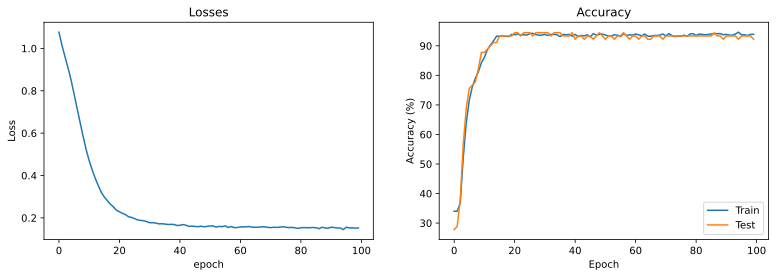

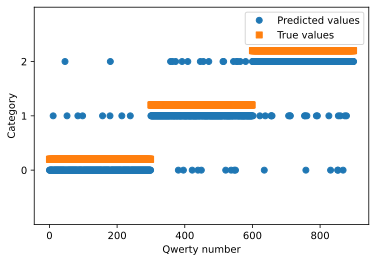

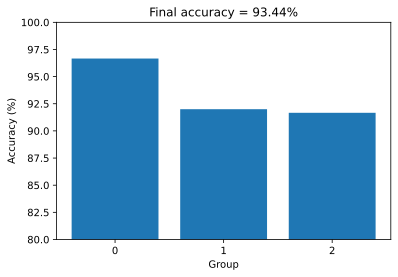

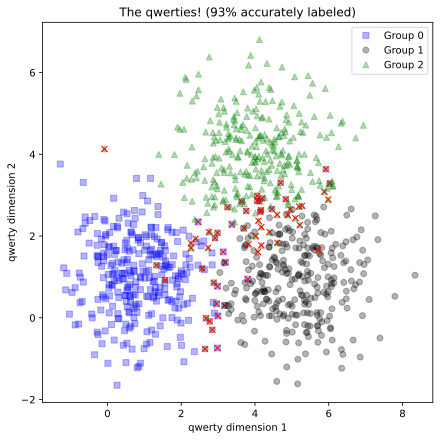

In [20]:
def function2trainTheModel():

  # number of epochs
  numepochs = 100
  
  # create a new model
  net,lossfun,optimizer = createTheQwertyNet()

  # initialize losses
  losses   = torch.zeros(numepochs)
  trainAcc = []
  testAcc  = []

  # loop over epochs
  for epochi in range(numepochs):

    # switch on training mode
    net.train()

    # loop over training data batches
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # compute accuracy
      matches = torch.argmax(yHat,axis=1) == y     # booleans (false/true)
      matchesNumeric = matches.float()             # convert to numbers (0/1)
      accuracyPct = 100*torch.mean(matchesNumeric) # average and x100 
      batchAcc.append( accuracyPct )               # add to list of accuracies
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)

    # test accuracy
    net.eval()
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    with torch.no_grad(): # deactivates autograd
      yHat = net(X)
      
    # compare the following really long line of code to the training accuracy lines
    testAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1)==y).float()) ) 
  # end epochs

  # function output
  return trainAcc,testAcc,losses,net


# run the model
trainAcc,testAcc,losses,net = function2trainTheModel()

fig,ax = plt.subplots(1,2,figsize=(13,4))

ax[0].plot(losses.detach())
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('epoch')
ax[0].set_title('Losses')

ax[1].plot(trainAcc,label='Train')
ax[1].plot(testAcc,label='Test')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_xlabel('Epoch')
ax[1].set_title('Accuracy')
ax[1].legend()
plt.show()

# run the data through the model to get the categorical predictions
yHat = net(data)
predictions = torch.argmax(yHat,axis=1)

# and plot those against the real data
plt.plot(predictions,'o',label='Predicted values')
plt.plot(labels+.2,'s',label='True values')
plt.xlabel('Qwerty number')
plt.ylabel('Category')
plt.yticks([0,1,2])
plt.ylim([-1,3])
plt.legend()
plt.show()

# recode each prediction by accuracy
accuracy = (predictions == labels).float()

# compute overall accuracy
totalAcc = torch.mean(100*accuracy).item()

# and average by group
accuracyByGroup = np.zeros(3)
for i in range(3):
  accuracyByGroup[i] = 100*torch.mean(accuracy[labels==i])

plt.bar(range(3),accuracyByGroup)
plt.ylim([80,100])
plt.xticks([0,1,2])
plt.xlabel('Group')
plt.ylabel('Accuracy (%)')
plt.title(f'Final accuracy = {totalAcc:.2f}%')
plt.show()

# Finally, show the qwerties in their native space, labeled by accuracy

# data markers
colorShapes = [ 'bs','ko','g^' ]


# show the data
fig = plt.figure(figsize=(7,7))

# plot correct and incorrect labeled data
for i in range(3):
  # plot all data points for this label
  plt.plot(data[labels==i,0],data[labels==i,1],colorShapes[i],
                 alpha=.3,label=f'Group {i}')
  
  # cross out the incorrect ones
  idxErr = (accuracy==0) & (labels==i)
  plt.plot(data[idxErr,0],data[idxErr,1],'rx')

plt.title(f'The qwerties! ({totalAcc:.0f}% accurately labeled)')
plt.xlabel('qwerty dimension 1')
plt.ylabel('qwerty dimension 2')
plt.legend()
plt.show()

# 6. SGD with Momentum

In [21]:
# create a class for the model
def createTheQwertyNet(momentum):

  class qwertyNet(nn.Module):
    def __init__(self):
      super().__init__()

      ### input layer
      self.input = nn.Linear(2,8)
      
      ### hidden layer
      self.fc1 = nn.Linear(8,8)

      ### output layer
      self.output = nn.Linear(8,3)

    # forward pass
    def forward(self,x):
      x = F.relu( self.input(x) )
      x = F.relu( self.fc1(x) )
      return self.output(x)
  
  # create the model instance
  net = qwertyNet()
  
  # loss function
  lossfun = nn.CrossEntropyLoss()

  # optimizer (note extra input!)
  optimizer = torch.optim.SGD(net.parameters(),lr=.01,momentum=momentum)

  return net,lossfun,optimizer


# confirm that the optimizer has momentum
optim = createTheQwertyNet(.9)[2]
optim

SGD (
Parameter Group 0
    dampening: 0
    lr: 0.01
    momentum: 0.9
    nesterov: False
    weight_decay: 0
)

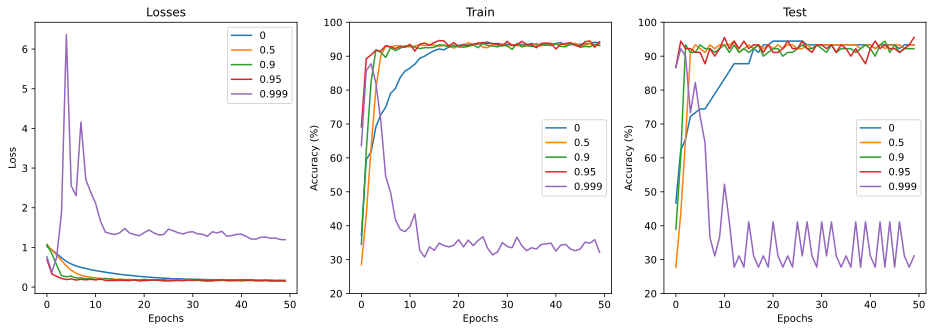

In [22]:
# a function that trains the model


# number of epochs
numepochs = 50


def funtion2trainTheModel(momentum):
  
  # create a new model
  net,lossfun,optimizer = createTheQwertyNet(momentum)

  # initialize losses
  losses   = torch.zeros(numepochs)
  trainAcc = []
  testAcc  = []

  # loop over epochs
  for epochi in range(numepochs):

    # switch on training mode
    net.train()

    # loop over training data batches
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # compute accuracy
      matches = torch.argmax(yHat,axis=1) == y     # booleans (false/true)
      matchesNumeric = matches.float()             # convert to numbers (0/1)
      accuracyPct = 100*torch.mean(matchesNumeric) # average and x100 
      batchAcc.append( accuracyPct )               # add to list of accuracies
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)

    # test accuracy
    net.eval()
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    with torch.no_grad(): # deactivates autograd
      yHat = net(X)
      
    # compare the following really long line of code to the training accuracy lines
    testAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1)==y).float()) ) 
  # end epochs

  # function output
  return trainAcc,testAcc,losses,net




# momentum values to use
momenta = [0,.5,.9,.95,.999]

# initialize results matrix
results = np.zeros((numepochs,len(momenta),3))

# test all momentum values on the same data (different model instances)
for idx,mom in enumerate(momenta):
  trainAcc,testAcc,losses,net = funtion2trainTheModel(mom)
  results[:,idx,0] = losses
  results[:,idx,1] = trainAcc
  results[:,idx,2] = testAcc


fig,ax = plt.subplots(1,3,figsize=(16,5))

for i in range(3):
  ax[i].plot(results[:,:,i])
  ax[i].legend(momenta)
  ax[i].set_xlabel('Epochs')
  if i==0:
    ax[i].set_ylabel('Loss')
  else:
    ax[i].set_ylabel('Accuracy (%)')
    ax[i].set_ylim([20,100])

ax[0].set_title('Losses')
ax[1].set_title('Train')
ax[2].set_title('Test')

plt.show()

# 7. Optimizers

In [23]:
# create a class for the model
def createTheQwertyNet(optimizerAlgo):

  class qwertyNet(nn.Module):
    def __init__(self):
      super().__init__()

      ### input layer
      self.input = nn.Linear(2,8)
      
      ### hidden layer
      self.fc1 = nn.Linear(8,8)

      ### output layer
      self.output = nn.Linear(8,3)

    # forward pass
    def forward(self,x):
      x = F.relu( self.input(x) )
      x = F.relu( self.fc1(x) )
      return self.output(x)
  
  # create the model instance
  net = qwertyNet()
  
  # loss function
  lossfun = nn.CrossEntropyLoss()

  # optimizer
  optifun = getattr( torch.optim,optimizerAlgo )
  optimizer = optifun(net.parameters(),lr=.01)

  return net,lossfun,optimizer


# test the model with optimizer type as input

# try 'SGD', 'RMSprop', and 'Adam'
optim = createTheQwertyNet('RMSprop')[2]
optim


def funtion2trainTheModel(optimizerType):

  # number of epochs
  numepochs = 50
  
  # create a new model
  net,lossfun,optimizer = createTheQwertyNet(optimizerType)

  # initialize losses
  losses   = torch.zeros(numepochs)
  trainAcc = []
  testAcc  = []

  # loop over epochs
  for epochi in range(numepochs):

    # switch on training mode
    net.train()

    # loop over training data batches
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # compute accuracy
      matches = torch.argmax(yHat,axis=1) == y     # booleans (false/true)
      matchesNumeric = matches.float()             # convert to numbers (0/1)
      accuracyPct = 100*torch.mean(matchesNumeric) # average and x100 
      batchAcc.append( accuracyPct )               # add to list of accuracies
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)

    # test accuracy
    net.eval()
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    with torch.no_grad(): # deactivates autograd
      yHat = net(X)
      
    # compare the following really long line of code to the training accuracy lines
    testAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1)==y).float()) ) 
  # end epochs

  # function output
  return trainAcc,testAcc,losses,net


# a function that plots the results
def plotTheResults(optimizerType):

  # compute accuracy over entire dataset (train+test)
  yHat = net(data)
  predictions = torch.argmax(yHat,axis=1)
  accuracy = (predictions == labels).float()
  totalAcc = torch.mean(100*accuracy).item()

  # and accuracy by group
  accuracyByGroup = np.zeros(3)
  for i in range(3):
    accuracyByGroup[i] = 100*torch.mean(accuracy[labels==i])


  # create the figure
  fig,ax = plt.subplots(2,2,figsize=(10,6))

  # plot the loss function
  ax[0,0].plot(losses.detach())
  ax[0,0].set_ylabel('Loss')
  ax[0,0].set_xlabel('epoch')
  ax[0,0].set_title(f'{optimizerType}: Losses')

  # plot the accuracy functions
  ax[0,1].plot(trainAcc,label='Train')
  ax[0,1].plot(testAcc,label='Test')
  ax[0,1].set_ylabel('Accuracy (%)')
  ax[0,1].set_xlabel('Epoch')
  ax[0,1].set_title(f'{optimizerType}: Accuracy')
  ax[0,1].legend()

  # plot overall accuracy by group
  ax[1,0].bar(range(3),accuracyByGroup)
  ax[1,0].set_ylim([np.min(accuracyByGroup)-5,np.max(accuracyByGroup)+5])
  ax[1,0].set_xticks([0,1,2])
  ax[1,0].set_xlabel('Group')
  ax[1,0].set_ylabel('Accuracy (%)')
  ax[1,0].set_title(f'{optimizerType}: Accuracy by group')

  # scatterplot of correct and incorrect labeled data
  colorShapes = [ 'bs','ko','g^' ] # data markers
  for i in range(3):
    # plot all data points
    ax[1,1].plot(data[labels==i,0],data[labels==i,1],colorShapes[i],
                 alpha=.3,label=f'Group {i}')
    
    # cross-out the incorrect ones
    idxErr = (accuracy==0) & (labels==i)
    ax[1,1].plot(data[idxErr,0],data[idxErr,1],'rx')

  ax[1,1].set_title(f'{optimizerType}: Total accuracy: {totalAcc:.2f}%')
  ax[1,1].set_xlabel('qwerty dimension 1')
  ax[1,1].set_ylabel('qwerty dimension 2')
  ax[1,1].legend()
  
  plt.tight_layout()
  plt.show()

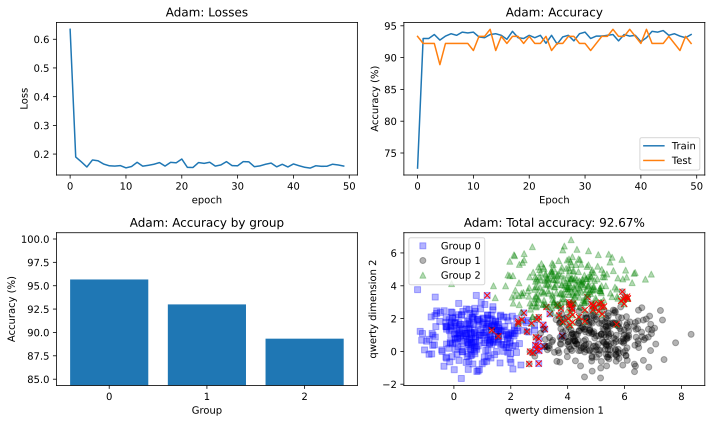

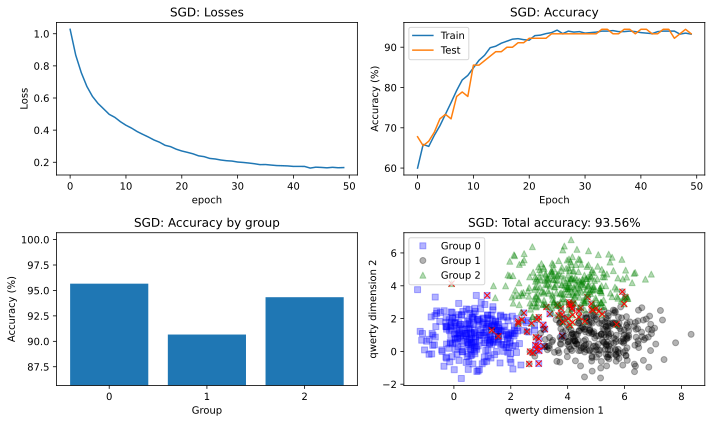

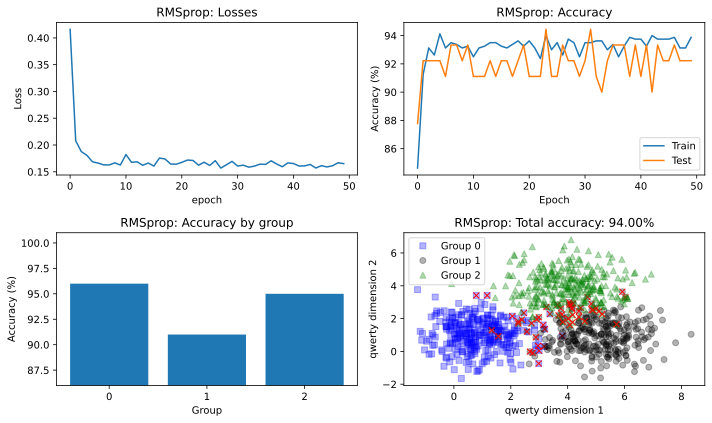

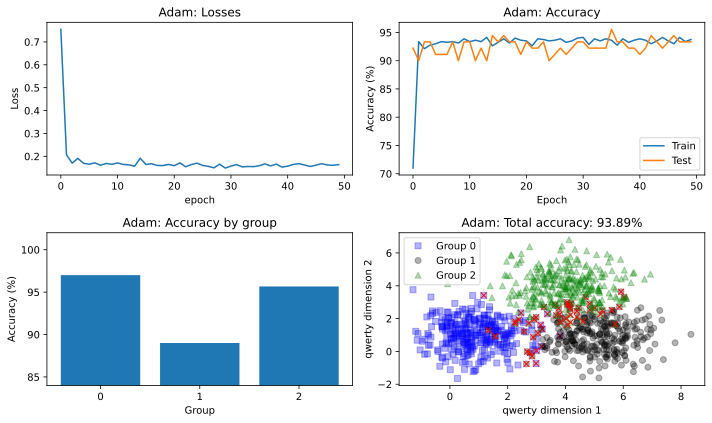

In [24]:
# run the model for one optimizer
optimizerType = 'Adam'
trainAcc,testAcc,losses,net = funtion2trainTheModel(optimizerType)

# visualize!
plotTheResults(optimizerType)

# now run through all of them

# average performance
performance = []

for opto in ['SGD','RMSprop','Adam']:
  trainAcc,testAcc,losses,net = funtion2trainTheModel(opto)
  plotTheResults(opto)

  # store the final results
  train = np.mean(trainAcc[-10:])
  test  = np.mean(testAcc[-10:])

  performance.append( f'{opto}: train {train:.1f}%, test {test:.1f}%' )

# 8. Learning Rate Decay

In [33]:
# create a class for the model
def createTheQwertyNet(initialLR):

  class qwertyNet(nn.Module):
    def __init__(self):
      super().__init__()

      ### input layer
      self.input = nn.Linear(2,8)
      
      ### hidden layer
      self.fc1 = nn.Linear(8,8)

      ### output layer
      self.output = nn.Linear(8,3)

    # forward pass
    def forward(self,x):
      x = F.relu( self.input(x) )
      x = F.relu( self.fc1(x) )
      return self.output(x)
  
  # create the model instance
  net = qwertyNet()
  
  # loss function
  lossfun = nn.CrossEntropyLoss()

  # optimizer and LR scheduler
  optimizer = torch.optim.SGD(net.parameters(),lr=initialLR)
  stepsize  = batchsize*len(train_loader)
  scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=stepsize,gamma=.5)

  return net,lossfun,optimizer,scheduler

# how many steps until the learning rate changes?
len(train_loader)*batchsize

800

Batch 0, epoch 0: LR=0.01
Batch 1, epoch 0: LR=0.01
Batch 2, epoch 0: LR=0.01
Batch 3, epoch 0: LR=0.01
Batch 4, epoch 0: LR=0.01
Batch 5, epoch 0: LR=0.005
Batch 6, epoch 0: LR=0.005
Batch 7, epoch 0: LR=0.005
Batch 8, epoch 0: LR=0.005
Batch 9, epoch 0: LR=0.005
Batch 0, epoch 1: LR=0.0025
Batch 1, epoch 1: LR=0.0025
Batch 2, epoch 1: LR=0.0025
Batch 3, epoch 1: LR=0.0025
Batch 4, epoch 1: LR=0.0025
Batch 5, epoch 1: LR=0.00125
Batch 6, epoch 1: LR=0.00125
Batch 7, epoch 1: LR=0.00125
Batch 8, epoch 1: LR=0.00125
Batch 9, epoch 1: LR=0.00125
Batch 0, epoch 2: LR=0.000625
Batch 1, epoch 2: LR=0.000625
Batch 2, epoch 2: LR=0.000625
Batch 3, epoch 2: LR=0.000625
Batch 4, epoch 2: LR=0.000625
Batch 5, epoch 2: LR=0.0003125
Batch 6, epoch 2: LR=0.0003125
Batch 7, epoch 2: LR=0.0003125
Batch 8, epoch 2: LR=0.0003125
Batch 9, epoch 2: LR=0.0003125


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


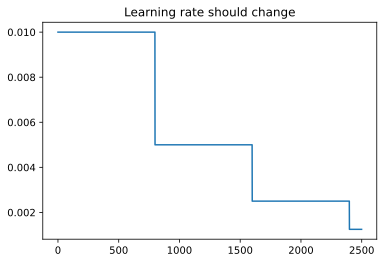

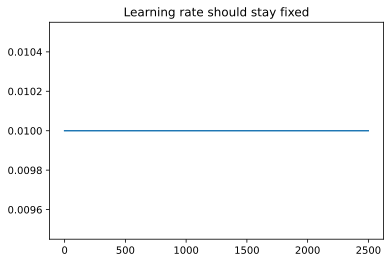

In [34]:
# create a network
net = createTheQwertyNet(.01)[0]

# a new optimizer
optimizer = torch.optim.SGD(net.parameters(),lr=.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=5,gamma=1/2)

# test the change in learning rate
for epoch in range(3):
  for batchnum in range(10):
    print(f'Batch {batchnum}, epoch {epoch}: LR={scheduler.get_last_lr()[0]}')
    scheduler.step()


# a function that trains the model

def funtion2trainTheModel(initialLR,toggleDynamicLR):

  # number of epochs
  numepochs = 50
  
  # create a new model
  net,lossfun,optimizer,scheduler = createTheQwertyNet(initialLR)

  # initialize losses
  losses    = torch.zeros(numepochs)
  trainAcc  = []
  testAcc   = []
  currentLR = []


  # loop over epochs
  for epochi in range(numepochs):

    # switch on training mode
    net.train()

    # loop over training data batches
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # step the learning-rate scheduler
      if toggleDynamicLR:
        scheduler.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # compute accuracy
      matches = torch.argmax(yHat,axis=1) == y     # booleans (false/true)
      matchesNumeric = matches.float()             # convert to numbers (0/1)
      accuracyPct = 100*torch.mean(matchesNumeric) # average and x100 
      batchAcc.append( accuracyPct )               # add to list of accuracies

      currentLR.append( scheduler.get_last_lr()[0] )
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)

    # test accuracy
    net.eval()
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    with torch.no_grad(): # deactivates autograd
      yHat = net(X)
      
    # compare the following really long line of code to the training accuracy lines
    testAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1)==y).float()) )

  # end epochs

  # function output
  return trainAcc,testAcc,losses,net,currentLR


# test that the learning rate is really working
trainAcc,testAcc,losses,net,currentLR = funtion2trainTheModel(.01,True)
plt.plot(currentLR)
plt.title('Learning rate should change')
plt.show()

trainAcc,testAcc,losses,net,currentLR = funtion2trainTheModel(.01,False)
plt.plot(currentLR)
plt.title('Learning rate should stay fixed')
plt.show()

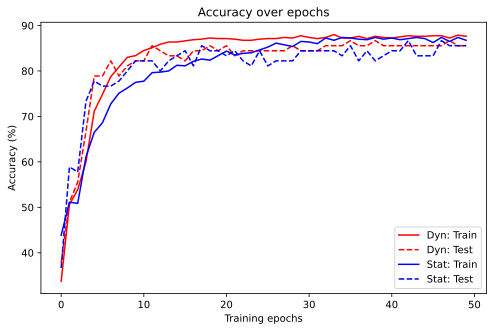

In [36]:
# now test with and without dynamic LR
trainAccDynamic,testAccDynamic,losses,net,currentLR = funtion2trainTheModel(.01,True)
trainAccStatic,testAccStatic,losses,net,currentLR   = funtion2trainTheModel(.01,False)

fig = plt.figure(figsize=(8,5))
plt.plot(trainAccDynamic,'r',label='Dyn: Train')
plt.plot(testAccDynamic,'r--',label='Dyn: Test')

plt.plot(trainAccStatic,'b',label='Stat: Train')
plt.plot(testAccStatic,'b--',label='Stat: Test')

plt.xlabel('Training epochs')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy over epochs')
plt.legend()
plt.show()

# Reference
These are codes learned from the Udemy

COURSE: A deep understanding of deep learning

TEACHER: Mike X Cohen, sincxpress.com

COURSE URL: udemy.com/course/dudl/?couponCode=202109